In [1]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
import shap
from xgboost import plot_importance
from matplotlib import pyplot

## Sales approach

In [2]:
df = pd.read_csv('sales_data_all.csv')
df['sale_date'] = pd.to_datetime(df['sale_date'])
df["quarter"] = df.sale_date.dt.quarter
df["profit"] = (df['regular_price'] - df['purchase_price']) * df['quantity']

def myfunc(q):

    # Filtering by quarter
    my_df = df[df.quarter == q]

    # Grouping by product_id and sum the quantities
    my_df_grouped = my_df.groupby('product_id').sum('quantity')

    # Compute the naive popularity index and scale it
    my_df_grouped['pop_index'] = my_df_grouped['quantity'] / my_df_grouped['quantity'].sum()
    my_df_grouped['pop_index_perc'] = (my_df_grouped['pop_index'] - my_df_grouped['pop_index'].min())\
                                            / (my_df_grouped['pop_index'].max() - my_df_grouped['pop_index'].min())

    # Compute the revenues index and scale it
    my_df_grouped['profit_perc'] = (my_df_grouped['profit'] - my_df_grouped['profit'].min())\
                                            / (my_df_grouped['profit'].max() - my_df_grouped['profit'].min())

    my_df_grouped.reset_index(inplace = True)
    return my_df_grouped

var = myfunc(1)

In [3]:
print('10 most popular products:\n', var.sort_values('pop_index_perc', ascending=False)['product_id'].head(10))

10 most popular products:
 649     110853
3759    156095
399     107645
2839    145377
4074    157318
2510    143220
3690    155431
4071    157315
876     122291
1184    128194
Name: product_id, dtype: int64


In [4]:
def ABC(X):
    top_ten = list(var[var['pop_index_perc'] > X].product_id.unique().tolist())
    my_df = var[var['product_id'].isin(top_ten)].reset_index(drop = True)
    perc = X*100
    print('Contribution to total revenues of the ', str(perc), '%', 'most popular products =', my_df.profit.sum()/var.profit.sum())
ABC(0.1)


Contribution to total revenues of the  10.0 % most popular products = 0.15404542458145007


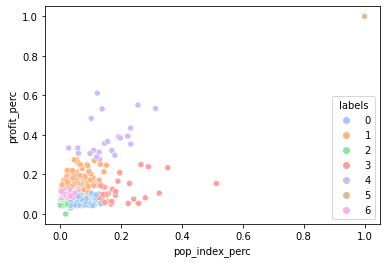

In [5]:
def vincolo_clustering():
    model = KMeans(n_clusters= 7,
                   init = 'k-means++')
    #model = DBSCAN(eps = 0.05, metric = 'manhattan')
    model.fit(var[['pop_index_perc', 'profit_perc']])
    var['labels'] = model.labels_
    sns.scatterplot(x = var['pop_index_perc'], y=var['profit_perc'], hue = var['labels'], palette="pastel")

vincolo_clustering()

In [18]:
#def vincolo_manual():
#
#    var['pop_label'] = 'D'
#    for i in range(len(var)):
#        if (var['pop_index_perc'][i] > 0.5) & (var['profit_perc'][i] > 0.5):
#            var['pop_label'][i] = 'A'
#        elif (var['pop_index_perc'][i] < 0.5) & (var['profit_perc'][i] > 0.5):
#            var['pop_label'][i] = 'B'
#        elif (var['pop_index_perc'][i] > 0.5) & (var['profit_perc'][i] < 0.5):
#            var['pop_label'][i] = 'C'
        

#    sns.scatterplot(data=var, x='pop_index_perc', y='profit_perc', hue='pop_label', size="pop_label")

#vincolo_manual()

## Clicks approach

In [7]:
# Import click dataset
df = pd.read_csv('clicks_concatenato.csv', usecols=['date','seller','position','price_max','price_min','price','type','product_id'])
df['date'] = pd.to_datetime(df['date'])
df['quarter'] = df['date'].dt.quarter
df['date'] = df['date'].dt.date

def click(q):

    # Filter by quarter
    copydf = df[df.quarter == q]

    def preprocessing(dataframe):

        # Count the number of click
        total_click = len(dataframe)

        # Group by product_id and count the occurrences
        df_tot = dataframe.groupby('product_id').size().reset_index()
        df_tot.rename(columns = {0: 'click'}, inplace = True)

        # Calculate the popularity index and normalize it
        df_tot['pop_index'] = df_tot['click']/total_click
        df_tot['pop_index_norm'] = (df_tot['pop_index'] - df_tot['pop_index'].min())\
                                            / (df_tot['pop_index'].max() - df_tot['pop_index'].min())
        return df_tot

    # Popularity index of the market
    my_df_tot = preprocessing(copydf)

    # Popularity index for seller 24
    my_df_24 = copydf[copydf['seller'] == 24]
    my_df_24 = preprocessing(my_df_24)

    # Merge the datasets, showing only products sold by s. 24
    final = pd.merge(my_df_tot, my_df_24, on='product_id', how='right', suffixes = ['total','24'])
    #sns.scatterplot(data = final, x = 'pop_index_normtotal', y = 'pop_index_norm24')
    return final

df_clicks = click(1)

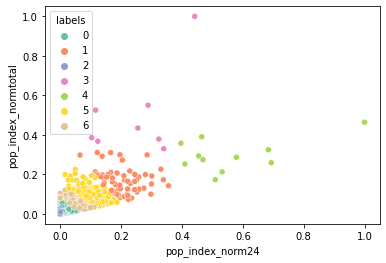

In [8]:
def clustering():
    model = KMeans(n_clusters= 7,
                   init = 'k-means++')
    #model = DBSCAN(eps = 0.05, metric = 'manhattan')
    model.fit(df_clicks[['pop_index_normtotal', 'pop_index_norm24']])
    df_clicks['labels'] = model.labels_
    sns.scatterplot(x = df_clicks['pop_index_norm24'], y=df_clicks['pop_index_normtotal'], hue = df_clicks['labels'], palette="Set2")

clustering()

In [9]:
clicks_merged = pd.merge(df, df_clicks, on='product_id', how='left')
clicks_merged['date'] = pd.to_datetime(clicks_merged['date'])
clicks_merged = clicks_merged[clicks_merged['date'].dt.year == 2021].dropna()

In [13]:
#X = clicks_merged.iloc[:, clicks_merged.columns != ["pop_index_normtotal",'product_id','pop_indextotal','click24','pop_index24','pop_index_norm24']]
X = clicks_merged.drop(['labels','clicktotal','pop_index_normtotal','date','product_id','pop_indextotal','click24','pop_index24','pop_index_norm24'], axis = 1)
X = pd.get_dummies(X, columns = ['type'])

y = clicks_merged["pop_index_normtotal"]
                       
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Train dataset shape: {train_X.shape}")
print(f"Test dataset shape: {test_X.shape}")

Train dataset shape: (828714, 8)
Test dataset shape: (207179, 8)


In [14]:
#xgb_r = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_r = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
xgb_r.fit(train_X, train_y)
pred = xgb_r.predict(test_X)
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

[09:53:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.056141


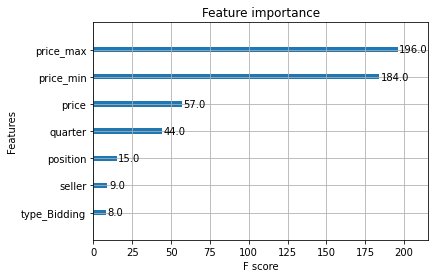

In [15]:
plot_importance(xgb_r)
pyplot.show()

In [16]:
X_sampled = train_X.sample(100, random_state=10)
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb_r)
shap_values = explainer.shap_values(X_sampled)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


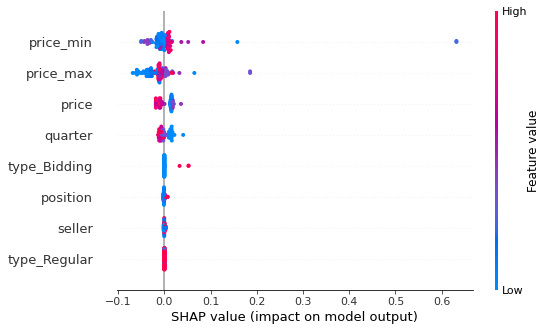

In [17]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)